# Import Library Needed

In [ ]:
# !pip install pyspark

In [191]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
import requests
from pandas import DataFrame
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline


# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains, year, when, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

# Fetching data from kaggle to Drive

In [126]:
# # Set-up Env Variable for kaggle Config
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Data Science/Enroll Kelas Big Data Analytics dengan PySpark/'

# # Download and Unzip the dataset
# # Dengan cara ***Pilih Dataset*** di ***Kaggle***, lalu klik ***Titik Tiga***, dan pilih ***Copy API Command***

# # # Tentukan path untuk menyimpan dataset
# path_to_save = '/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Data Science/Enroll Kelas Big Data Analytics dengan PySpark/Dataset/'

# # # Buat direktori jika belum ada
# os.makedirs(path_to_save, exist_ok=True)

# # # Unduh dataset menggunakan perintah kaggle
# !kaggle datasets download -d arnabchaki/data-science-salaries-2023 -p '{path_to_save}'

In [127]:
# # # Ekstrak dataset
# !unzip '{path_to_save}/data-science-salaries-2023.zip' -d '{path_to_save}'

# # # Hapus file zip jika diperlukan
# os.remove(f'{path_to_save}data-science-salaries-2023.zip')

# Import Dataset

## Load Manual First

In [166]:
# Inisialisasi SparkSession - - - # spark = SparkSession.builder.appName("").getOrCreate()
spark = SparkSession.builder.master("local[*]").appName("pyspark").getOrCreate()

In [129]:
from google.colab import files

# Mengunggah file
uploaded = files.upload()

# Menampilkan nama file yang diunggah
for filename in uploaded.keys():
    print('File yang diunggah:', filename)

Saving ds_salaries.csv to ds_salaries (1).csv
File yang diunggah: ds_salaries (1).csv


In [167]:
df = spark.read.csv("/content/ds_salaries.csv", header=True, inferSchema=True)

## Spark Simple SQL Query

In [168]:
#Creating a table from the dataframe
df.createOrReplaceTempView("Data_Science_Salaries") #temporary view

# df.saveAsTable("covid_data") #Save as a table
# df.write.mode("overwrite").saveAsTable("covid_data") #Save as table and overwrite table if exits

In [169]:
df2 = spark.sql("SELECT * from Data_Science_Salaries")
df2.printSchema()
df2.show()

root
 |-- work_year: integer (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- salary_currency: string (nullable = true)
 |-- salary_in_usd: integer (nullable = true)
 |-- employee_residence: string (nullable = true)
 |-- remote_ratio: integer (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
| 

In [176]:
groupDF = spark.sql("SELECT job_title, count(*) as job_count FROM Data_Science_Salaries GROUP BY job_title")
sorted_groupDF = groupDF.orderBy("job_count", ascending=False)

sorted_groupDF.show()

+--------------------+---------+
|           job_title|job_count|
+--------------------+---------+
|       Data Engineer|     1040|
|      Data Scientist|      840|
|        Data Analyst|      612|
|Machine Learning ...|      289|
|  Analytics Engineer|      103|
|      Data Architect|      101|
|  Research Scientist|       82|
|   Applied Scientist|       58|
|Data Science Manager|       58|
|   Research Engineer|       37|
|         ML Engineer|       34|
|        Data Manager|       29|
|Machine Learning ...|       26|
|Data Science Cons...|       24|
|Data Analytics Ma...|       22|
|Computer Vision E...|       18|
|        AI Scientist|       16|
|Business Data Ana...|       15|
|     BI Data Analyst|       15|
|     Data Specialist|       14|
+--------------------+---------+
only showing top 20 rows



# Explore and Processing Data

In [177]:
# Pengecekan nilai yang hilang
missing_values = {col: df.filter(df[col].isNull()).count() for col in df.columns}
print("Nilai yang hilang:")
for col, count in missing_values.items():
    print(col, ": ", count)

Nilai yang hilang:
work_year :  0
experience_level :  0
employment_type :  0
job_title :  0
salary :  0
salary_currency :  0
salary_in_usd :  0
employee_residence :  0
remote_ratio :  0
company_location :  0
company_size :  0


In [178]:
#Viewing the dataframe schema
df.printSchema()

root
 |-- work_year: integer (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- salary_currency: string (nullable = true)
 |-- salary_in_usd: integer (nullable = true)
 |-- employee_residence: string (nullable = true)
 |-- remote_ratio: integer (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)



In [179]:
#Summary stats
df.describe().show()

+-------+------------------+----------------+---------------+--------------------+------------------+---------------+------------------+------------------+------------------+----------------+------------+
|summary|         work_year|experience_level|employment_type|           job_title|            salary|salary_currency|     salary_in_usd|employee_residence|      remote_ratio|company_location|company_size|
+-------+------------------+----------------+---------------+--------------------+------------------+---------------+------------------+------------------+------------------+----------------+------------+
|  count|              3755|            3755|           3755|                3755|              3755|           3755|              3755|              3755|              3755|            3755|        3755|
|   mean|2022.3736351531293|            NULL|           NULL|                NULL|190695.57177097205|           NULL|137570.38988015978|              NULL|46.271637816245004|      

In [180]:
df.show(5)

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              SE|             FT|Principal Data Sc...| 80000|            EUR|        85847|                ES|         100|              ES|           L|
|     2023|              MI|             CT|         ML Engineer| 30000|            USD|        30000|                US|         100|              US|           S|
|     2023|              MI|             CT|         ML Engineer| 25500|            USD|        25500|                US|         100|              US|           S|
|     2023

In [181]:
df.count()

3755

In [182]:
df.columns

['work_year',
 'experience_level',
 'employment_type',
 'job_title',
 'salary',
 'salary_currency',
 'salary_in_usd',
 'employee_residence',
 'remote_ratio',
 'company_location',
 'company_size']

In [183]:
df.select('job_title', 'salary').show(5)

+--------------------+------+
|           job_title|salary|
+--------------------+------+
|Principal Data Sc...| 80000|
|         ML Engineer| 30000|
|         ML Engineer| 25500|
|      Data Scientist|175000|
|      Data Scientist|120000|
+--------------------+------+
only showing top 5 rows



In [184]:
df.show(5)

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              SE|             FT|Principal Data Sc...| 80000|            EUR|        85847|                ES|         100|              ES|           L|
|     2023|              MI|             CT|         ML Engineer| 30000|            USD|        30000|                US|         100|              US|           S|
|     2023|              MI|             CT|         ML Engineer| 25500|            USD|        25500|                US|         100|              US|           S|
|     2023

In [188]:
df.show()

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              SE|             FT|Principal Data Sc...| 80000|            EUR|        85847|                ES|         100|              ES|           L|
|     2023|              MI|             CT|         ML Engineer| 30000|            USD|        30000|                US|         100|              US|           S|
|     2023|              MI|             CT|         ML Engineer| 25500|            USD|        25500|                US|         100|              US|           S|
|     2023

In [192]:
# Year of Work Experience
current_year = 2024
df = df.withColumn("work_experience", current_year - col("work_year"))

In [193]:
# Remote Ratio
df = df.withColumn("remote_category",
                   when(col("remote_ratio") == 100, "Full Remote")
                   .when(col("remote_ratio") > 0, "Partial-Remote")
                   .otherwise("On-Site"))

In [194]:
# Convert PySpark DataFrame to Pandas DataFrame
pd_df = df.toPandas() # but we don't use this, cause we try to use Pyspark

# EDA (Exploratory Data Analysis)

## Job dengan Title Gaji diatas 400 ribu USD

In [205]:
filtered_df_1 = df.filter((df["salary"] > 400000) & (df["salary_currency"] == "USD"))
sorted_df_1 = filtered_df_1.orderBy(df["salary"].desc()).select("job_title","salary")

sorted_df_1.show()

+--------------------+------+
|           job_title|salary|
+--------------------+------+
|  Research Scientist|450000|
|Applied Machine L...|423000|
|Principal Data Sc...|416000|
|      Data Scientist|412000|
| Data Analytics Lead|405000|
+--------------------+------+



In [206]:
sorted_df_1.toPandas()

,job_title,salary
0,Research Scientist,450000
1,Applied Machine Learning Scientist,423000
2,Principal Data Scientist,416000
3,Data Scientist,412000
4,Data Analytics Lead,405000


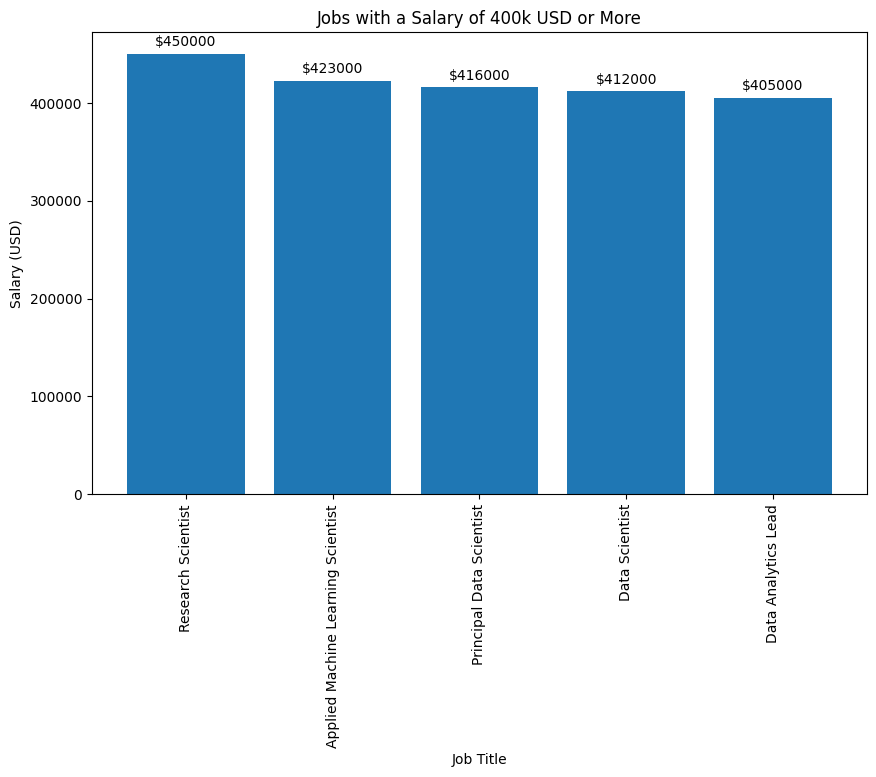

In [241]:
plt.figure(figsize=(10, 6))
plt.bar(sorted_df_1.toPandas()['job_title'], sorted_df_1.toPandas()['salary'])
plt.xlabel('Job Title')
plt.ylabel('Salary (USD)')
plt.title('Jobs with a Salary of 400k USD or More')
plt.xticks(rotation=90)

# Menambahkan label data per batang
for i, salary in enumerate(sorted_df_1.toPandas()['salary']):
    plt.text(i, salary + 5000, f"${salary}", ha='center', va='bottom', rotation=0)
plt.show();

## Job Title Terbanyak

In [227]:
# Assuming you have already computed the grouped DataFrame
filtered_df_2 = spark.sql("SELECT job_title, count(*) as job_count FROM Data_Science_Salaries GROUP BY job_title").toPandas()

# Sort the DataFrame by job_count in descending order and select top 10 rows
top_10_jobs = filtered_df_2.sort_values(by='job_count', ascending=False).head(10)

top_10_jobs

,job_title,job_count
90,Data Engineer,1040
46,Data Scientist,840
48,Data Analyst,612
28,Machine Learning Engineer,289
61,Analytics Engineer,103
83,Data Architect,101
39,Research Scientist,82
60,Applied Scientist,58
64,Data Science Manager,58
62,Research Engineer,37


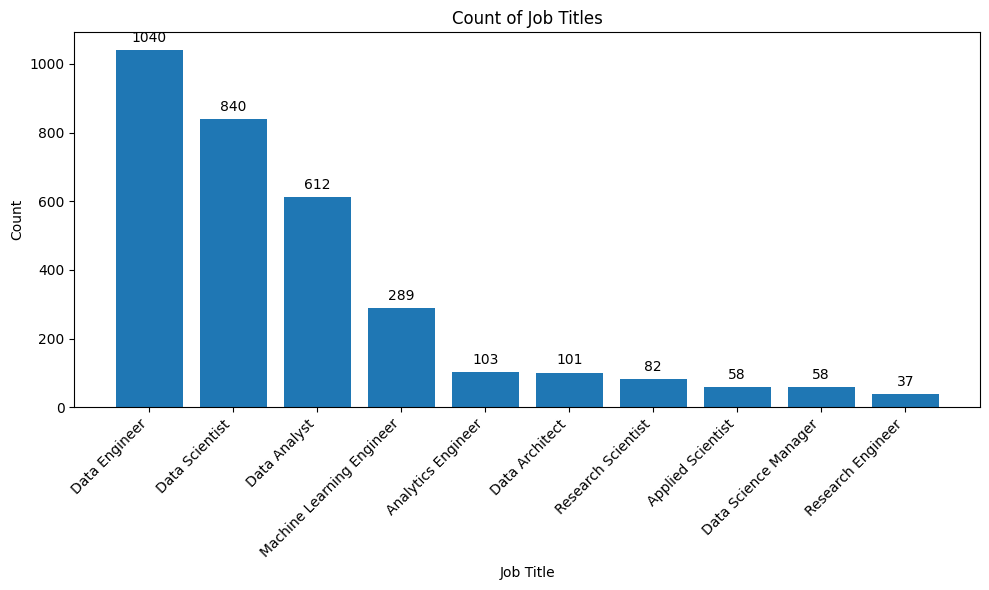

In [238]:
plt.figure(figsize=(10, 6))
plt.bar(top_10_jobs['job_title'], top_10_jobs['job_count'])
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.title('Count of Job Titles')
plt.xticks(rotation=45, ha='right')

# Menambahkan label data per batang
for i, countjob in enumerate(top_10_jobs['job_count']):
    plt.text(i, countjob + 15, f"{countjob}", ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show();

## Company Size based on Company Location

In [264]:
# Assuming you have already computed the grouped DataFrame
filtered_df_3 = spark.sql("SELECT company_location, company_size, count(*) as company_count FROM Data_Science_Salaries GROUP BY company_location, company_size ORDER BY company_location, company_size, company_count")

In [267]:
filtered_df_3.show()

+----------------+------------+-------------+
|company_location|company_size|company_count|
+----------------+------------+-------------+
|              AE|           L|            1|
|              AE|           S|            2|
|              AL|           S|            1|
|              AM|           S|            1|
|              AR|           L|            2|
|              AR|           S|            1|
|              AS|           L|            1|
|              AS|           M|            1|
|              AS|           S|            1|
|              AT|           L|            3|
|              AT|           M|            2|
|              AT|           S|            1|
|              AU|           L|            8|
|              AU|           M|            5|
|              AU|           S|            1|
|              BA|           S|            1|
|              BE|           L|            1|
|              BE|           M|            2|
|              BE|           S|   

## Countries with the most companies

In [293]:
# Assuming you have already computed the grouped DataFrame
filtered_df_3 = spark.sql("SELECT company_location, count(*) as company_location_count FROM Data_Science_Salaries GROUP BY company_location").toPandas()

# Sort the DataFrame by job_count in descending order and select top 10 rows
top_15_countries = filtered_df_3.sort_values(by='company_location_count', ascending=False).head(15)
top_15_countries = top_15_countries.reset_index(drop = True)
top_15_countries_pakai = top_15_countries.iloc[1:15]

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='company_location', ylabel='company_location_count'>

Text(0.5, 0, 'Company Location')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Top 15 Countries by Company Location --- US adalah Negara dengan jumlah Terbanyak: 3040')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'GB'),
  Text(1, 0, 'CA'),
  Text(2, 0, 'ES'),
  Text(3, 0, 'IN'),
  Text(4, 0, 'DE'),
  Text(5, 0, 'FR'),
  Text(6, 0, 'BR'),
  Text(7, 0, 'PT'),
  Text(8, 0, 'AU'),
  Text(9, 0, 'GR'),
  Text(10, 0, 'NL'),
  Text(11, 0, 'MX'),
  Text(12, 0, 'IE'),
  Text(13, 0, 'AT')])

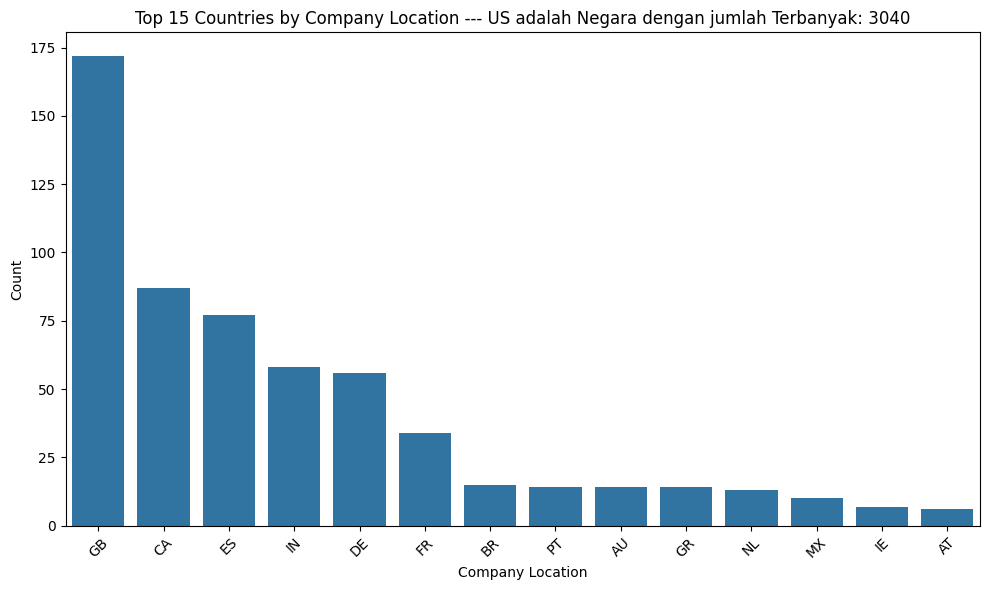

In [294]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="company_location", y="company_location_count", data=top_15_countries_pakai)
plt.xlabel('Company Location')
plt.ylabel('Count')
plt.title(f"Top 15 Countries by Company Location --- {top_15_countries.iloc[0]['company_location']} adalah Negara dengan jumlah Terbanyak: {top_15_countries.iloc[0]['company_location_count']}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
